In [49]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import pandas as pd
from ai4neb import manage_RM
%matplotlib inline
import matplotlib as mpl
from astropy.table import Table
from astropy.io import fits
import pyneb as pn
mpl.rc('image', cmap='jet')
dir_RMs = 'RMs/'
dir_CSVs = 'CSVs/'

In [504]:
N2 = pn.Atom('N', 2)
O3 = pn.Atom('O', 3)
O2 = pn.Atom('O', 2)
Ne3 = pn.Atom('Ne', 3)

In [2]:
obs = Table.read('./BOND_sourcesSPIRALS-HEBCD.txt', format='ascii')
mask = (obs['F3869'].data > 0) & (obs['F7135'].data > 0)& (obs['F5876'].data > 0)
obs = obs[mask]
print(obs.keys())

['id', 'r', 'name', 'F3727', 'eF3727', 'F3869', 'eF3869', 'F4363', 'eF4363', 'F5007', 'eF5007', 'F5755', 'eF5755', 'F5876', 'eF5876', 'F6584', 'eF6584', 'F7135', 'eF7135', 'limF4363', 'limF5755']


In [ ]:
fits_table_filename = '/Users/christophemorisset/Google Drive/Pro/HII_EPM/eelg_dr16.GasProp.fits'
with fits.open(fits_table_filename) as hdul:
    #print('---------- INFOS ---------')
    print(hdul.info())
    #print('---------- header 0 ---------')
    #print(hdul[0].header.cards)
    #print('---------- header 1 ---------')
    #print(hdul[18].header.cards)
    data = hdul[18].data
    hd = hdul[18].header
names = hd.cards['LABELS'][1].split(',')
names2 = [n[2:-1] for n in names]
names2[-1] = names2[-1][:-1]
lam = hd.cards['WAVE'][1]
lambdas = [float(wl[:-1]) for wl in lam[1:-1].split()]
df = pd.DataFrame([d[0] for d in data]).T
df.columns = names2
RC = pn.RedCorr(law = 'F99')
RC.setCorr(df['6563 HI']/df['4861 HI']/2.86, wave1=6563, wave2=4861)
RC.E_BV = (RC.E_BV < 0).choose(RC.E_BV, 0)
for line, wl in zip(names2, lambdas):
    df[line+' cor'] = df[line] * RC.getCorr(wl)
    print(line, wl)
for line, wl in zip(names2, lambdas):
    df[line+' Hb'] = df[line+' cor'] / df['4861 HI cor']
df2 = df[['5007 [OIII] Hb','6584 [NII] Hb', '3726 [OII] Hb', '3729 [OII] Hb',
         '3869 [NeIII] Hb', '7136 [ArIII] Hb', '5876 HeI Hb', '4363 [OIII] Hb', '5755 [NII] Hb']]
df2 = df2.dropna(subset=['5007 [OIII] Hb','6584 [NII] Hb', '3726 [OII] Hb', '3729 [OII] Hb',
                         '3869 [NeIII] Hb', '7136 [ArIII] Hb', '5876 HeI Hb'])
len(df2)
df2['RO3'] = df2['5007 [OIII] Hb'] * 1.33 / df2['4363 [OIII] Hb']
#df2['TOpp'] = O3.getTemDen(df2['4363 [OIII] Hb']/df2['5007 [OIII] Hb'], den=1e2, wave1=4363, wave2=5007)
df2['TOpp'] = 7840 - 1.357 * df2.RO3 + 484400 / df2.RO3

df2['TOp'] = 13970 / (10000/df2['TOpp'] + 0.385)
den = 1e2*np.ones_like(df2['TOpp'])
#df2['TNp'] = N2.getTemDen(df2['5755 [NII] Hb']/df2['6584 [NII] Hb'], den=1e2, wave1=5755, wave2=6584)
Opp = O3.getIonAbundance(df2['5007 [OIII] Hb'], df2['TOpp'], den, wave=5007, Hbeta=1)
Op = O2.getIonAbundance(df2['3726 [OII] Hb'] + df2['3729 [OII] Hb'], df2['TOp'], den, to_eval='L(3726)+L(3729)', Hbeta=1)
                    
df2['O'] = np.log10(Op + Opp)
df2['N'] = np.log10(N2.getIonAbundance(df2['6584 [NII] Hb'], df2['TOp'], den, to_eval='L(6584)', Hbeta=1) * (Op+Opp)/Op)

In [502]:
TeN2 = N2.getTemDen(obs['F5755']/obs['F6584'], den=1e2, wave1=5755, wave2=6584)
TeO3 = O3.getTemDen(obs['F4363']/obs['F5007'], den=1e2, wave1=4363, wave2=5007)

obs['TeN2'] = TeN2
obs['TeO3'] = TeO3

In [4]:
m1 = np.isnan(obs['TeN2'])
TeN2_low = 3000 + 0.7 *  obs['TeO3'][m1]
m2 = np.isnan(obs['TeO3'])
TeO3_high = (obs['TeN2'][m2] - 3000) / 0.7
obs['TeN2'][m1] = TeN2_low
obs['TeO3'][m2] = TeO3_high

In [5]:
Op = O2.getIonAbundance(obs['F3727'], tem=obs['TeN2'], den=100*np.ones(len(obs)), to_eval='L(3729) + L(3726)', Hbeta=1)
Opp = O3.getIonAbundance(obs['F5007'], tem=obs['TeO3'], den=100*np.ones(len(obs)), to_eval='L(5007)', Hbeta=1)
Np = N2.getIonAbundance(obs['F6584'], tem=obs['TeN2'], den=100*np.ones(len(obs)), to_eval='L(6584)', Hbeta=1)
obs['O'] = np.log10(Op + Opp)
obs['N'] = np.log10(Np * (Op + Opp)/Op)

In [444]:
def get_data_17(datafile='data_BOND_17.csv', force=False):
    if not os.path.exists(dir_CSVs + datafile) or force:
        sel = """SELECT
                log10(O__3_500684A/H__1_486133A) as O3,  
                log10(N__2_658345A/H__1_486133A) as N2, 
                log10(BLND_372700A/H__1_486133A) as O2, 
                log10((NE_3_386876A + NE_3_396747A)/H__1_486133A) as Ne3,
                log10(AR_3_713579A/H__1_486133A) as Ar3,
                log10(HE_1_587564A/H__1_486133A) as He1,
                log10(BLND_436300A/O__3_500684A) as rO3,
                log10(BLND_575500A/N__2_658345A) as rN2,
                NITROGEN - OXYGEN as NO,
                OXYGEN as O,
                logU_mean as logU,
                SUBSTRING(com2, 5) as fr,
                SUBSTRING(com3, 6) as age,
                HbFrac
                FROM tab_17 
                WHERE ref = 'BOND_2' """
        db = pymysql.connect(host=os.environ['MdB_HOST'], 
                                user=os.environ['MdB_USER'], 
                                passwd=os.environ['MdB_PASSWD'], 
                                db=os.environ['MdB_DB_17'])    
        res = pd.read_sql(sel, con=db)
        res.fr = res.fr.astype('float64') 
        res.age = res.age.astype('float64')/1e6
        db.close()
        res.to_csv(dir_CSVs + datafile)
    else:
        res = pd.read_csv(dir_CSVs + datafile)
    return res
res = get_data_17(force=False)
res = res[res.HbFrac > 0.95]
print('Total number of models:', len(res))

Total number of models: 21060


In [452]:
pn.atomicData.usedFiles

{'N2': ['n_ii_atom_FFT04.dat', 'n_ii_coll_T11.dat'],
 'O3': ['o_iii_atom_FFT04-SZ00.dat', 'o_iii_coll_SSB14.dat'],
 'O2': ['o_ii_atom_Z82-WFD96.dat', 'o_ii_coll_Kal09.dat'],
 'H1': ['h_i_rec_SH95.hdf5']}

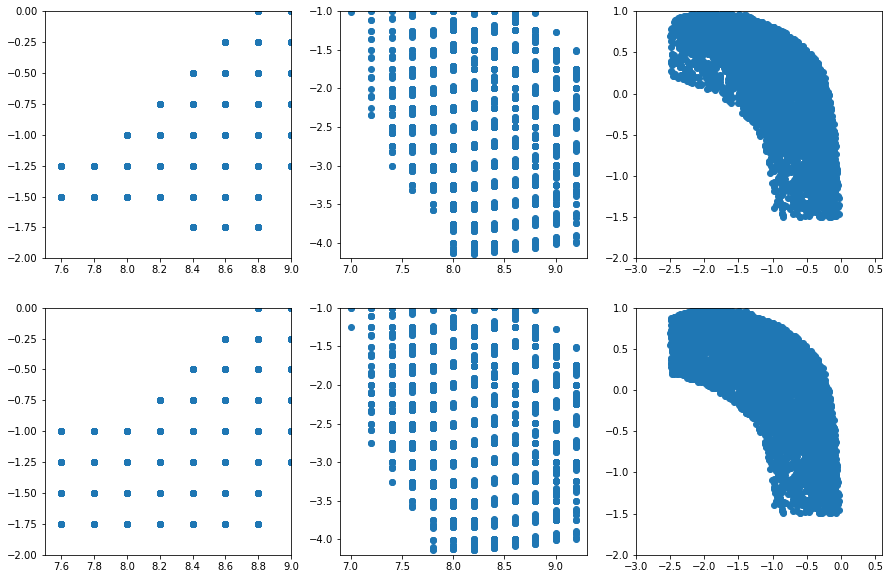

In [518]:
Z = (12 + res.O).values


m1o = (Z < 7.93).choose(res.NO < (1.489 * Z - 12.896), res.NO < -1.093)
m2o = (Z < 8.25).choose(res.NO > (1.489 * Z - 14.900), res.NO > -1.693)

m1 = (Z < 7.93).choose(res.NO < (1.489 * Z - 12.896), res.NO < -1.093)
m2 = (Z < 8.9).choose(res.NO > (1.489 * Z - 14.900), res.NO > -1.693)
m1mine = (Z < 7.93).choose(res.NO < (1.489 * Z - 12.9), res.NO < -0.99)
m2mine = (Z < 8.95).choose(res.NO > (1.489 * Z - 14.900), res.NO > -1.76)

m3 = res.logU > (5 - 1.25 * Z)
m4 = res.logU < (10 - 1.25 * Z)

y = res.N2 - np.log10(2.86)
a_low = -30.79 + 1.14*(y+0.60) + 0.27*(y+0.60)**2
b_low = 5.74 * (y+0.60)
c_low = 31.09
a_up = -30.79 + 1.14*(y-0.30) + 0.27*(y-0.30)**2
b_up = 5.74 * (y-0.30)
c_up = 31.09

m5 = res.O3 > (a_low * np.tanh(b_low) - c_low - 0.70)
m6 = res.O3 < (a_up * np.tanh(b_up) - c_up + 0.10)
m7 = res.O3 > -1.5
m8 = y > -2.5

res1o = res[m1o & m2o & m3 & m4]
res1 = res[m1mine & m2mine & m3 & m4 & m5 & m6 & m7 & m8]
#print(len(res))
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(15,10))
ax1.scatter(12 + res1o.O, res1o.NO)
ax1.set_xlim(7.5, 9.)
ax1.set_ylim(-2., 0.)

ax2.scatter(12 + res1o.O, res1o.logU)
ax2.set_xlim(6.9, 9.3)
ax2.set_ylim(-4.2, -1);

ax3.scatter(res1o.N2- np.log10(2.86), res1o.O3)
ax3.set_xlim(-3, 0.6)
ax3.set_ylim(-2, 1)

ax4.scatter(12 + res1.O, res1.NO)
ax4.set_xlim(7.5, 9.)
ax4.set_ylim(-2., 0.)

ax5.scatter(12 + res1.O, res1.logU)
ax5.set_xlim(6.9, 9.3)
ax5.set_ylim(-4.2, -1);

ax6.scatter(res1.N2- np.log10(2.86), res1.O3)
ax6.set_xlim(-3, 0.6)
ax6.set_ylim(-2, 1);

#f.savefig('filterNO-LogU.pdf')

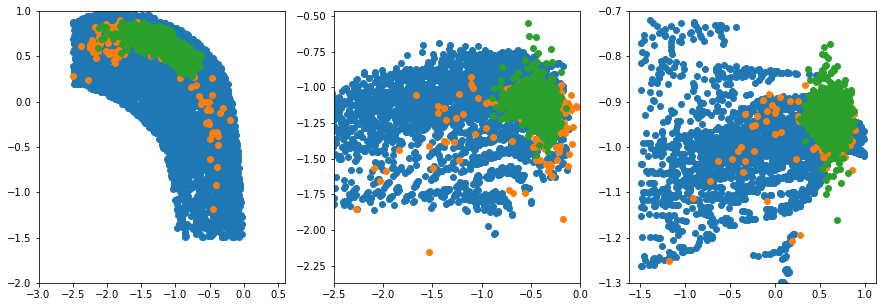

In [517]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.scatter(res1.N2- np.log10(2.86), res1.O3)
ax1.scatter(np.log10(obs['F6584']/2.86), np.log10(obs['F5007']))
ax1.scatter(np.log10(df2['6584 [NII] Hb']/2.86), np.log10(df2['5007 [OIII] Hb']))
ax1.set_xlim(-3, 0.6)
ax1.set_ylim(-2, 1);

ax2.scatter(res1.Ne3, res1.Ar3)
ax2.scatter(np.log10(obs['F3869']*1.33), np.log10(obs['F7135']))
ax2.scatter(np.log10(df2['3869 [NeIII] Hb']), np.log10(df2['7136 [ArIII] Hb']))
ax2.set_xlim(-2.5, 0.)

ax3.scatter(res1.O3, res1.He1)
ax3.scatter(np.log10(obs['F5007']), np.log10(obs['F5876']))
ax3.scatter(np.log10(df2['5007 [OIII] Hb']), np.log10(df2['5876 HeI Hb']))
ax3.set_ylim(-1.3, -0.7);

In [519]:
res = res1
print(len(res))
X_keys = ['O3', 'N2', 'O2', 'Ne3', 'Ar3', 'He1']#, 'rO3', 'rN2']
y_keys = ['O', 'NO']#, 'logU']
X_train = np.array(res[X_keys])
y_train = np.array(res[y_keys])

4597


In [468]:
def make_RM(type_='ANN', force=False, **kwargs):
    name = 'AbDetX6y2cut2'
    RM = manage_RM(RM_filename=dir_RMs + '{}_{}'.format(name, type_), verbose=True)
    if not RM.model_read or force:
        if type_ in ('XGB', 'K_ANN', 'Poly'):
            RM_type = type_
        else:
            RM_type = 'SK_{}'.format(type_)
        RM = manage_RM(RM_type = RM_type, X_train=X_train, y_train=y_train, verbose=True, scaling=True, split_ratio=0.2)
        RM.init_RM(**kwargs)
        RM.train_RM()
        RM.save_RM(dir_RMs + '{}_{}'.format(name, type_), save_test=True, save_train=True)   
    RM.predict()
    print('{}: Trained with {} models in {:.2f}s, tested with {} models. Score: {}'.format(type_, 
                                                                                           RM.N_train, 
                                                                                           RM.training_time, 
                                                                                           RM.N_test,
                                                                                           np.log10(1-np.asarray(RM.train_score))))
    
    return(RM)

In [470]:
force=True

In [471]:
RM_ANN = make_RM(type_= 'ANN', max_iter=20000, tol=1e-8, solver='adam', activation='tanh', 
                 hidden_layer_sizes=(10, 20, 10), force=force)

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/AbDetX6y2cut2_ANN.ai4neb_sk
Train data scaled. 
Test data scaled. 
Training set size = 7955, Test set size = 1989
Training set size = 7955, Test set size = 1989
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 3677, Test set size = 920
Train data scaled. 
Test data scaled. 
Training set size = 3677, Test set size = 920
Training set size = 3677, Test set size = 920
Regression Model SK_ANN
Training 6 inputs for 2 outputs with 3677 data
RM trained, with 690 iterations. Score = 0.998
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 20, 10), max_iter=20000,
             tol=1e-08)
Training time 6.1 s.
RM save to RMs/AbDetX6y2cut2_ANN.ai4neb_sk
Predicting from 6 inputs to 2 outputs using 920 data in 0.00 secs.
ANN: Trained with 3677 models in 6.09s, tested with 920 models. Score: [-2.81044633]


In [472]:
RM_ANNK = make_RM(type_= 'K_ANN', max_iter=20000, tol=1e-8, solver='adam', activation='tanh', 
                 hidden_layer_sizes=(40, 60, 40), force=force)

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/AbDetX6y2cut2_K_ANN.ai4neb_k0
RM loaded from RMs/AbDetX6y2cut2_K_ANN.ai4neb_k1
Train data scaled. 
Test data scaled. 
Training set size = 7955, Test set size = 1989
Training set size = 7955, Test set size = 1989
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 3677, Test set size = 920
Train data scaled. 
Test data scaled. 
Training set size = 3677, Test set size = 920
Training set size = 3677, Test set size = 920
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 40)                280       
_________________________________________________________________
dense_45 (Dense)             (None, 60)                2460      
_________________________________________________________

In [473]:
RM_XGB = make_RM(type_='XGB', learning_rate=.015, n_estimators=2000, max_depth=25, force=force) # needs xgboost to be installed. 

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/AbDetX6y2cut2_XGB.ai4neb_xgb0
RM loaded from RMs/AbDetX6y2cut2_XGB.ai4neb_xgb1
RM loaded from RMs/AbDetX6y2cut2_XGB.ai4neb_xgb2
Train data scaled. 
Test data scaled. 
Training set size = 7955, Test set size = 1989
Training set size = 7955, Test set size = 1989
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 3677, Test set size = 920
Train data scaled. 
Test data scaled. 
Training set size = 3677, Test set size = 920
Training set size = 3677, Test set size = 920
Regression Model XGB
Training 6 inputs for 2 outputs with 3677 data


/Users/christophemorisset/anaconda3/lib/python3.8/site-packages/xgboost/core.py:442: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


RM trained. Score = 1.000
RM trained. Score = 1.000
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.015, max_delta_step=0, max_depth=25,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.015, max_delta_step=0, max_depth=25,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n

In [474]:
RM_SVM = make_RM(type_='SVM', kernel='rbf', C=10, epsilon=0.01, tol=1e-8, force=force) #

Instantiation. V 0.17
Training set size = 0, Test set size = 0
RM loaded from RMs/AbDetX6y2cut2_SVM.ai4neb_sk
Train data scaled. 
Test data scaled. 
Training set size = 7955, Test set size = 1989
Training set size = 7955, Test set size = 1989
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 3677, Test set size = 920
Train data scaled. 
Test data scaled. 
Training set size = 3677, Test set size = 920
Training set size = 3677, Test set size = 920
Regression Model SK_SVM
Training 6 inputs for 2 outputs with 3677 data
RM trained. Score = 0.990
RM trained. Score = 0.993
SVR(C=10, epsilon=0.01, tol=1e-08)
SVR(C=10, epsilon=0.01, tol=1e-08)
Training time 25.1 s.
RM save to RMs/AbDetX6y2cut2_SVM.ai4neb_sk
Predicting from 6 inputs to 2 outputs using 920 data in 0.05 secs.
SVM: Trained with 3677 models in 25.07s, tested with 920 models. Score: [-2.02129026 -2.12525314]


In [488]:
RM_Poly = make_RM(type_='Poly', degree=7, force=force) #

Instantiation. V 0.17
Training set size = 0, Test set size = 0
No ai4neb file found for RMs/AbDetX6y2cut2_Poly
Training set size = 0, Test set size = 0
Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 3677, Test set size = 920
Train data scaled. 
Test data scaled. 
Training set size = 3677, Test set size = 920
Training set size = 3677, Test set size = 920
Regression Model Poly
Training 6 inputs for 2 outputs with 3677 data
RM trained. Score = 0.998
RM trained. Score = 0.999
LinearRegression()
LinearRegression()
Training time 2.3 s.
Do not know how to save Poly machine
Predicting from 6 inputs to 2 outputs using 920 data in 0.01 secs.
Poly: Trained with 3677 models in 2.25s, tested with 920 models. Score: [-2.74449592 -2.82780402]


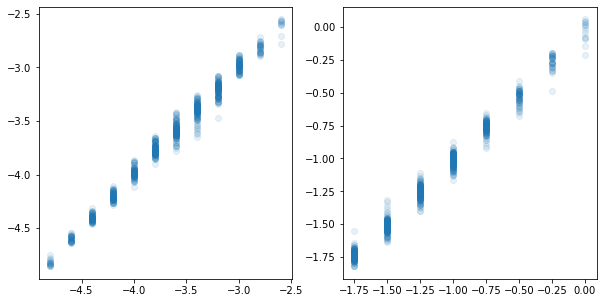

In [476]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.scatter(RM_ANN.y_test_ori[:,0], RM_ANN.pred[:,0], alpha=.1)
ax2.scatter(RM_ANN.y_test_ori[:,1], RM_ANN.pred[:,1], alpha=.1)

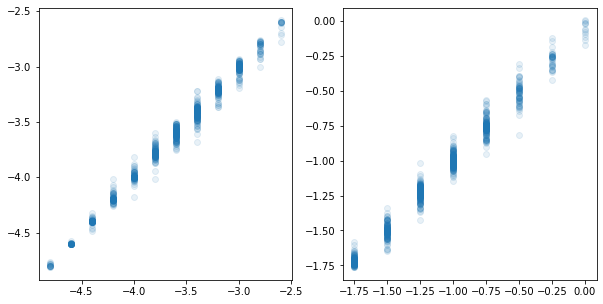

In [477]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.scatter(RM_XGB.y_test_ori[:,0], RM_XGB.pred[:,0], alpha=.1)
ax2.scatter(RM_XGB.y_test_ori[:,1], RM_XGB.pred[:,1], alpha=.1)

(-2.5, 0.1)

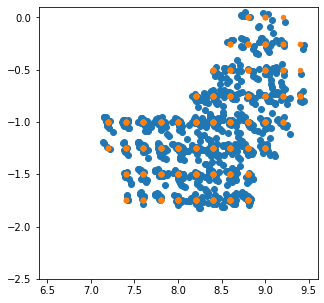

In [478]:
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(12+RM_ANN.pred[:,0], RM_ANN.pred[:,1], alpha=1)
ax.scatter(12+RM_ANN.y_test_ori[:,0], RM_ANN.y_test_ori[:,1], s=20)
ax.set_xlim(6.4, 9.6)
ax.set_ylim(-2.5, 0.1)

(-2.5, 0.1)

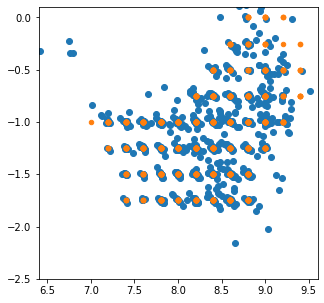

In [489]:
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(12+RM_Poly.pred[:,0], RM_Poly.pred[:,1], alpha=1)
ax.scatter(12+RM_Poly.y_test_ori[:,0], RM_Poly.y_test_ori[:,1], s=20)
ax.set_xlim(6.4, 9.6)
ax.set_ylim(-2.5, 0.1)

(-2.5, 0.1)

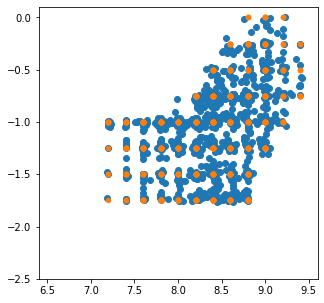

In [480]:
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(12+RM_XGB.pred[:,0], RM_XGB.pred[:,1], alpha=1)
ax.scatter(12+RM_XGB.y_test_ori[:,0], RM_XGB.y_test_ori[:,1], s=20)
ax.set_xlim(6.4, 9.6)
ax.set_ylim(-2.5, 0.1)

In [490]:
X_test = np.log10(np.asarray((obs['F5007'].data, 
                              obs['F6584'].data,
                              obs['F3727'].data,
                              obs['F3869'].data*1.3, 
                              obs['F7135'].data, 
                              obs['F5876'].data )))
RM_ANN.set_test(X_test.T)
RM_ANN.predict()
RM_ANNK.set_test(X_test.T)
RM_ANNK.predict()
RM_XGB.set_test(X_test.T)
RM_XGB.predict()
RM_Poly.set_test(X_test.T)
RM_Poly.predict()
RM_SVM.set_test(X_test.T)
RM_SVM.predict()

Test data scaled. 
Training set size = 3677, Test set size = 156
Predicting from 6 inputs to 2 outputs using 156 data in 0.00 secs.
Test data scaled. 
Training set size = 3677, Test set size = 156
Predicting from 6 inputs to 2 outputs using 156 data in 0.04 secs.
Test data scaled. 
Training set size = 3677, Test set size = 156
Predicting from 6 inputs to 2 outputs using 156 data in 0.01 secs.
Test data scaled. 
Training set size = 3677, Test set size = 156
Predicting from 6 inputs to 2 outputs using 156 data in 0.01 secs.
Test data scaled. 
Training set size = 3677, Test set size = 156
Predicting from 6 inputs to 2 outputs using 156 data in 0.02 secs.


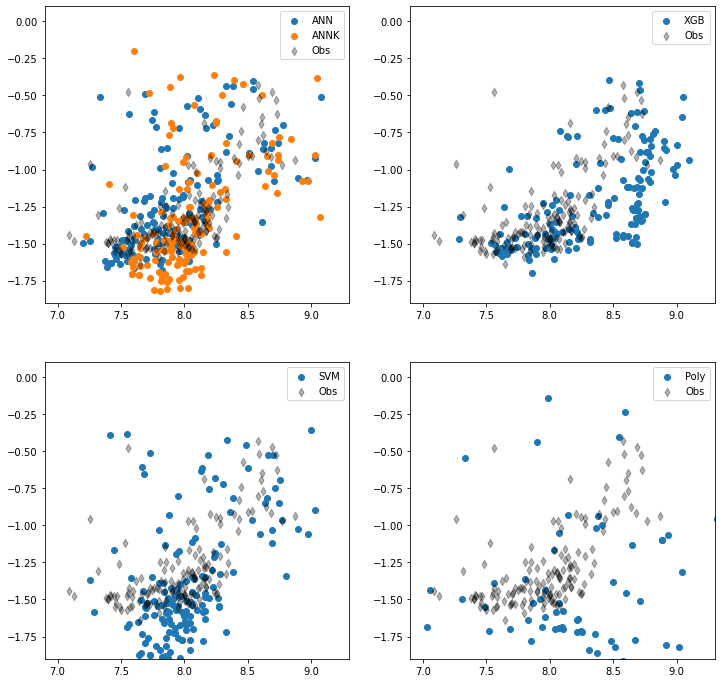

In [491]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
ax1.scatter(12+RM_ANN.pred[:,0], RM_ANN.pred[:,1], label='ANN')
ax1.scatter(12+RM_ANNK.pred[:,0], RM_ANNK.pred[:,1], label='ANNK')
ax2.scatter(12+RM_XGB.pred[:,0], RM_XGB.pred[:,1], label='XGB')
ax3.scatter(12+RM_SVM.pred[:,0], RM_SVM.pred[:,1], label='SVM')
ax4.scatter(12+RM_Poly.pred[:,0], RM_Poly.pred[:,1], label='Poly')

for ax in (ax1, ax2, ax3, ax4):
    ax.scatter(12+obs['O'], obs['N']-obs['O'], label='Obs', c='k',marker='d', alpha=0.3)
    ax.set_xlim(6.9, 9.3)
    ax.set_ylim(-1.9, 0.1)
    ax.legend()


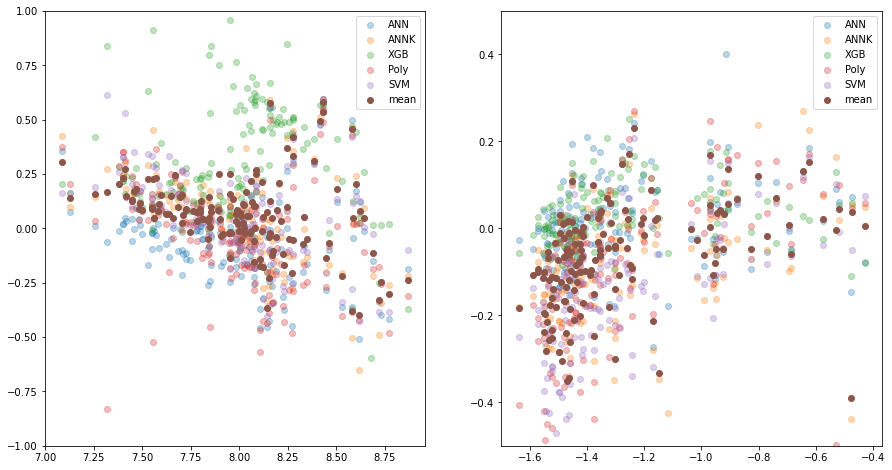

In [483]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.scatter(12+obs['O'], RM_ANN.pred[:,0] - obs['O'], label='ANN', alpha=0.3)
ax1.scatter(12+obs['O'], RM_ANNK.pred[:,0] - obs['O'], label='ANNK', alpha=0.3)
ax1.scatter(12+obs['O'], RM_XGB.pred[:,0] - obs['O'], label='XGB', alpha=0.3)
ax1.scatter(12+obs['O'], RM_Poly.pred[:,0] - obs['O'], label='Poly', alpha=0.3)
ax1.scatter(12+obs['O'], RM_SVM.pred[:,0] - obs['O'], label='SVM', alpha=0.3)
ax1.scatter(12+obs['O'], (RM_SVM.pred[:,0] + RM_ANN.pred[:,0] + RM_ANNK.pred[:,0] + RM_XGB.pred[:,0] + RM_Poly.pred[:,0] )/5 - obs['O'], label='mean')
ax1.legend()
ax1.set_ylim(-1., 1.)
ax2.scatter(obs['N'] - obs['O'], RM_ANN.pred[:,1] - obs['N'] + obs['O'], label='ANN', alpha=0.3)
ax2.scatter(obs['N'] - obs['O'], RM_ANNK.pred[:,1] - obs['N'] + obs['O'], label='ANNK', alpha=0.3)
ax2.scatter(obs['N'] - obs['O'], RM_XGB.pred[:,1] - obs['N'] + obs['O'], label='XGB', alpha=0.3)
ax2.scatter(obs['N'] - obs['O'], RM_Poly.pred[:,1] - obs['N'] + obs['O'], label='Poly', alpha=0.3)
ax2.scatter(obs['N'] - obs['O'], RM_SVM.pred[:,1] - obs['N'] + obs['O'], label='SVM', alpha=0.3)
ax2.scatter(obs['N'] - obs['O'], (RM_SVM.pred[:,1] + RM_ANN.pred[:,1] + RM_ANNK.pred[:,1] + RM_XGB.pred[:,1] + RM_Poly.pred[:,1] )/5 - obs['N'] + obs['O'], label='mean')
ax2.legend()
ax2.set_ylim(-.5, .5);

In [484]:
print(np.nanstd(RM_ANN.pred[:,0] - obs['O']))
print(np.nanstd(RM_ANNK.pred[:,0] - obs['O']))
print(np.nanstd(RM_XGB.pred[:,0] - obs['O']))
print(np.nanstd(RM_Poly.pred[:,0] - obs['O']))
print(np.nanstd(RM_SVM.pred[:,0] - obs['O']))
print(np.nanstd((RM_SVM.pred[:,0] + RM_ANN.pred[:,0] + RM_Poly.pred[:,0] + RM_ANNK.pred[:,0] + RM_XGB.pred[:,0])/5 - obs['O']))
print(np.nanstd((RM_SVM.pred[:,0] + RM_ANN.pred[:,0] + RM_Poly.pred[:,0] + RM_ANNK.pred[:,0])/4 - obs['O']))

0.22347053077579332
0.22118315895596977
0.2572755403895054
0.8726602162156165
0.22799124336125026
0.29780645475345574
0.3448826138666518


In [393]:
fits_table_filename = '/Users/christophemorisset/Google Drive/Pro/HII_EPM/eelg_dr16.GasProp.fits'
with fits.open(fits_table_filename) as hdul:
    #print('---------- INFOS ---------')
    print(hdul.info())
    #print('---------- header 0 ---------')
    #print(hdul[0].header.cards)
    #print('---------- header 1 ---------')
    #print(hdul[18].header.cards)
    data = hdul[18].data
    hd = hdul[18].header
names = hd.cards['LABELS'][1].split(',')
names2 = [n[2:-1] for n in names]
names2[-1] = names2[-1][:-1]
lam = hd.cards['WAVE'][1]
lambdas = [float(wl[:-1]) for wl in lam[1:-1].split()]
df = pd.DataFrame([d[0] for d in data]).T
df.columns = names2
RC = pn.RedCorr(law = 'F99')
RC.setCorr(df['6563 HI']/df['4861 HI']/2.86, wave1=6563, wave2=4861)
RC.E_BV = (RC.E_BV < 0).choose(RC.E_BV, 0)
for line, wl in zip(names2, lambdas):
    df[line+' cor'] = df[line] * RC.getCorr(wl)
    print(line, wl)
for line, wl in zip(names2, lambdas):
    df[line+' Hb'] = df[line+' cor'] / df['4861 HI cor']

Filename: /Users/christophemorisset/Google Drive/Pro/HII_EPM/eelg_dr16.GasProp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1  NAMEFILES     1 BinTableHDU     26   1968R x 6C   [K, 20A, D, D, D, D]   
  2  REDDENING     1 BinTableHDU     58   1968R x 20C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  3  DENSITY       1 BinTableHDU     29   1968R x 6C   [D, D, D, D, D, D]   
  4  CRITICALDENSITY    1 BinTableHDU     25   1968R x 4C   [D, D, D, D]   
  5  TEMPERATURE    1 BinTableHDU     37   1968R x 10C   [D, D, D, D, D, D, D, D, D, D]   
  6  LINERATIOS    1 BinTableHDU    193   1968R x 88C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  7  IONICAB       1 BinTableHDU    

In [394]:
df.keys()

Index(['3726 [OII]', '3729 [OII]', '3869 [NeIII]', '4069 [SII]', '4102 HI',
       '4341 HI', '4363 [OIII]', '4471 HeI', '4659 [FeIII]', '4686 HeII',
       '4740 [ArIV]', '4861 HI', '5007 [OIII]', '5755 [NII]', '5876 HeI',
       '6300 [OI]', '6312 [SIII]', '6548 [NII]', '6563 HI', '6584 [NII]',
       '6678 HeI', '6716 [SII]', '6731 [SII]', '7065 HeI', '7136 [ArIII]',
       '7319 [OII]', '7330 [OII]', '9069 [SIII]', '9531 [SIII]',
       '3726 [OII] cor', '3729 [OII] cor', '3869 [NeIII] cor',
       '4069 [SII] cor', '4102 HI cor', '4341 HI cor', '4363 [OIII] cor',
       '4471 HeI cor', '4659 [FeIII] cor', '4686 HeII cor', '4740 [ArIV] cor',
       '4861 HI cor', '5007 [OIII] cor', '5755 [NII] cor', '5876 HeI cor',
       '6300 [OI] cor', '6312 [SIII] cor', '6548 [NII] cor', '6563 HI cor',
       '6584 [NII] cor', '6678 HeI cor', '6716 [SII] cor', '6731 [SII] cor',
       '7065 HeI cor', '7136 [ArIII] cor', '7319 [OII] cor', '7330 [OII] cor',
       '9069 [SIII] cor', '9531 [SIII] 

In [395]:
O3 = pn.Atom('O', 3)
N2 = pn.Atom('N', 2)
O2 = pn.Atom('O', 2)

In [437]:
df2 = df[['5007 [OIII] Hb','6584 [NII] Hb', '3726 [OII] Hb', '3729 [OII] Hb',
         '3869 [NeIII] Hb', '7136 [ArIII] Hb', '5876 HeI Hb', '4363 [OIII] Hb', '5755 [NII] Hb']]
df2 = df2.dropna(subset=['5007 [OIII] Hb','6584 [NII] Hb', '3726 [OII] Hb', '3729 [OII] Hb',
                         '3869 [NeIII] Hb', '7136 [ArIII] Hb', '5876 HeI Hb'])
len(df2)
RO3 = df2['5007 [OIII] Hb'] * 1.33 / df2['4363 [OIII] Hb']
#df2['TOpp'] = O3.getTemDen(df2['4363 [OIII] Hb']/df2['5007 [OIII] Hb'], den=1e2, wave1=4363, wave2=5007)
df2['TOpp'] = 7840 - 1.357 * RO3 + 484400 / RO3

df2['TOp'] = 13970 / (10000/df2['TOpp'] + 0.385)
den = 1e2*np.ones_like(df2['TOpp'])
#df2['TNp'] = N2.getTemDen(df2['5755 [NII] Hb']/df2['6584 [NII] Hb'], den=1e2, wave1=5755, wave2=6584)
Opp = O3.getIonAbundance(df2['5007 [OIII] Hb'], df2['TOpp'], den, wave=5007, Hbeta=1)
Op = O2.getIonAbundance(df2['3726 [OII] Hb']+df2['3729 [OII] Hb'], df2['TOp'], den, to_eval='L(3726)+L(3729)', Hbeta=1)
                    
df2['O'] = np.log10(Op + Opp)
df2['N'] = np.log10(N2.getIonAbundance(df2['6584 [NII] Hb'], df2['TOp'], den, to_eval='L(6584)', Hbeta=1) * (Op+Opp)/Op)

In [438]:
X_test = np.log10(np.asarray((df2['5007 [OIII] Hb'], 
                              df2['6584 [NII] Hb'],
                              df2['3726 [OII] Hb'] + df2['3729 [OII] Hb'],
                              df2['3869 [NeIII] Hb']*1.3, 
                              df2['7136 [ArIII] Hb'], 
                              df2['5876 HeI Hb'] )))
RM_ANN.set_test(X_test.T)
RM_ANN.predict()
RM_ANNK.set_test(X_test.T)
RM_ANNK.predict()
RM_XGB.set_test(X_test.T)
RM_XGB.predict()
RM_Poly.set_test(X_test.T)
RM_Poly.predict()
RM_SVM.set_test(X_test.T)
RM_SVM.predict()

Test data scaled. 
Training set size = 7955, Test set size = 1240
Predicting from 6 inputs to 2 outputs using 1240 data in 0.00 secs.
Test data scaled. 
Training set size = 7955, Test set size = 1240
Predicting from 6 inputs to 2 outputs using 1240 data in 0.05 secs.
Test data scaled. 
Training set size = 7955, Test set size = 1240
Predicting from 6 inputs to 2 outputs using 1240 data in 0.06 secs.
Test data scaled. 
Training set size = 7955, Test set size = 1240
Predicting from 6 inputs to 2 outputs using 1240 data in 0.01 secs.
Test data scaled. 
Training set size = 7955, Test set size = 1240
Predicting from 6 inputs to 2 outputs using 1240 data in 0.25 secs.


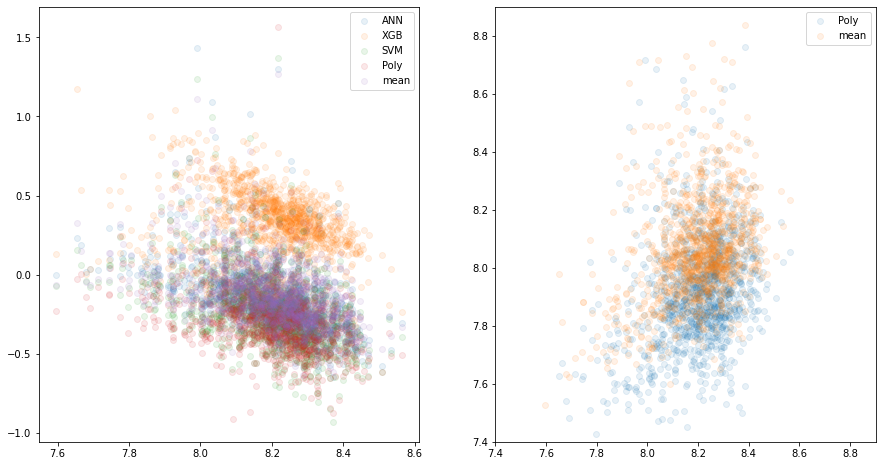

In [439]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.scatter(12+df2['O'], RM_ANN.pred[:,0] - df2['O'], label='ANN', alpha=0.1)
ax1.scatter(12+df2['O'], RM_XGB.pred[:,0] - df2['O'], label='XGB', alpha=0.1)
ax1.scatter(12+df2['O'], RM_SVM.pred[:,0] - df2['O'], label='SVM', alpha=0.1)
ax1.scatter(12+df2['O'], RM_Poly.pred[:,0] - df2['O'], label='Poly', alpha=0.1)
ax1.scatter(12+df2['O'], (RM_SVM.pred[:,0] + RM_ANN.pred[:,0]  + RM_Poly.pred[:,0] + RM_ANNK.pred[:,0] + RM_XGB.pred[:,0])/5 - df2['O'], label='mean', alpha=0.1)
ax1.legend()
ax2.scatter(12+df2['O'], 12+(RM_Poly.pred[:,0]), label='Poly', alpha=0.1)
ax2.scatter(12+df2['O'], 12+(RM_SVM.pred[:,0] + RM_ANN.pred[:,0]  + RM_Poly.pred[:,0] + RM_ANNK.pred[:,0] + RM_XGB.pred[:,0])/5, label='mean', alpha=0.1)
ax2.set_xlim(7.4, 8.9)
ax2.set_ylim(7.4, 8.9)
ax2.legend();

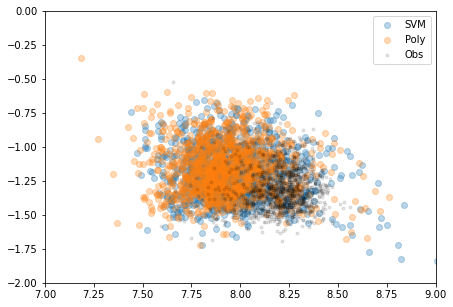

In [443]:
f, ax1 = plt.subplots(1, 1, figsize=(7,5))
ax1.scatter(12+RM_SVM.pred[:,0], RM_SVM.pred[:,1], label='SVM', alpha=0.3)
ax1.scatter(12+RM_Poly.pred[:,0], RM_Poly.pred[:,1], label='Poly', alpha=0.3)
ax1.scatter(12+df2.O, df2.N-df2.O, label='Obs', alpha=0.1, marker='.', c='k')
ax1.legend()
ax1.set_xlim(7, 9)
ax1.set_ylim(-2, 0);

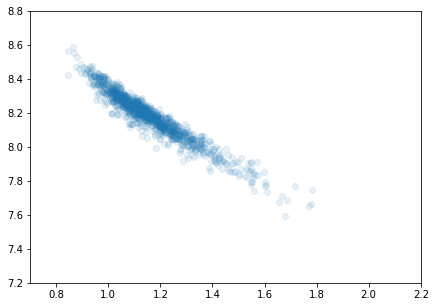

In [146]:
f, ax1 = plt.subplots(1, 1, figsize=(7,5))
ax1.scatter(df2.TOpp/1e4, 12+df2['O'], alpha=0.1)
ax1.set_xlim(0.7, 2.2)
ax1.set_ylim(7.2, 8.8);